In [1]:
import json
import re
from nltk import word_tokenize
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle
import operator
import toolz

import sys
sys.path.append('../shared/')

from Argument import Argument
from DataHandler import DataHandler

from crawler import encode, api_query, parse_json

# Read logs

In [2]:
logs = list()
with open('queries-2021-07-19-11-58-42-args-me-6999bf8866-85grs.log', 'r', encoding='utf-8') as file:
    for line in file.readlines():
        line = line.lstrip()
        logs.append(json.loads(line))
        
with open('queries-2021-05-06-11-41-59-args-me-6999bf8866-p7bj7.log', 'r', encoding='utf-8') as file:
    for line in file.readlines():
        line = line.lstrip()
        logs.append(json.loads(line))

In [3]:
len(logs)

1796167

In [4]:
queries = {l['text'] for l in logs if l['url'].startswith('http://www.args.me/search')}

In [5]:
queries.add('covid is a scam')

In [6]:
len(queries)

902

In [7]:
def clean(query):
    query = query.strip()
    query = re.sub(r'"', '', query)
    query = re.sub('\'', '', query)
    query = re.sub('#', '', query)
    query = re.sub('  ', ' ', query)
    query = query.lower()
    return query

BLACKLIST = {
    '><script >alert(String.fromCharCode(88,83,83))</script>',
    'Sdb06427c-A118ed4ac'.lower(),
    'subselect sql',
    'c#',
    'ubuntu',
    'dieses traumes',
    'Rap+Battle:+Trump+vs+Clinton'.lower(),
    'c++',
    'linux',
    'One problem might be that I thought we could use the args.me snippets as a baseline, but when I paste the full question into args.me, I get no results.'.lower(),
    'Rap+Battle+Trump+vs+Clinton'.lower(),
    'S7068d2b9-Ab5ad7e25'.lower(),
    'Sae50ee6c-Ab43a4651'.lower(),
}
def keep(query):
    if len(query) < 2:
        return False
    if not query[0].isalpha():
        return False
    if query in BLACKLIST:
        return False
    return True

In [8]:
queries = set(filter(keep, map(clean, queries)))

In [9]:
len(queries)

814

In [10]:
queries

{'abandon fossil fuels',
 'abortion',
 'abortion legalization',
 'abotion',
 'accounting',
 'administration',
 'advantage of fair skin',
 'afd',
 'african',
 'agile',
 'ai',
 'ai is good',
 'alcohol',
 'alien',
 'alien life',
 'aliens',
 'alkohol',
 'altmaier',
 'altright',
 'america citizenship',
 'america citizenship to everyone',
 'amsterdam',
 'animals',
 'animals new zeeland',
 'anime',
 'antifa',
 'apple',
 'apple is a good stock',
 'apples',
 'architecture',
 'arduino',
 'are all paper biased?',
 'are perfect avocados getting harder to find',
 'are social networking sites good for our society?',
 'are vaccinations safe?',
 'argument',
 'argument relevance',
 'argumentation',
 'argumentation for rationality of the christian belief in creation',
 'argumentation mining',
 'arsenal',
 'arsenal fc',
 'arsenal football club',
 'art',
 'art[0]',
 'artificial intelligenc',
 'artificial intelligence',
 'artificial meat',
 'asexuality',
 'asf',
 'astra zeneca covid vaccine',
 'atom energy

# Crawl arguments

In [180]:
%%time
arguments = list()
stances = dict()
for q in queries:
    try:
        respoonse = api_query(q)
        args, stc = parse_json(respoonse)
        arguments.extend(args)
        stances.update(stc)
    except:
        print(f'Could not query {q}')

No arguments returned for febreze.
No arguments returned for impfpflicht.
No arguments returned for grassland.
No arguments returned for vegetarism.
No arguments returned for bonn+is+a+german+city.
No arguments returned for sheikh+haseena.
No arguments returned for henning+washmuth.
No arguments returned for information+retrival.
No arguments returned for einheit.
No arguments returned for is+backoven+safe.
No arguments returned for many+locals+and+tourists+frequent+southern+california.
No arguments returned for lei+kuang.
No arguments returned for künstliche+intelligenz+im+unterricht.
No arguments returned for tony+ianno.
No arguments returned for emirates+stadium.
No arguments returned for asf.
No arguments returned for imkerei.
No arguments returned for is+charlie+watts+alive?.
No arguments returned for castism+in+india.
No arguments returned for klimaschutz.
No arguments returned for haus.
No arguments returned for klimawandel.
No arguments returned for hagen.
No arguments returned

Could not query high frequency taxes
Could not query nursing metaparadigm
Could not query bible
Could not query should children have mobile phones?
Could not query henning wachsmuth
Could not query tex
Could not query facism
Could not query vaccine
Could not query art[0]
Could not query is the sky blue?
Could not query wissenschaftskommunikation
Could not query bicycle
Could not query administration
Could not query ms dhoni
Could not query tomato plastic
Could not query schalke
Could not query should hydraulic fracturing be used
Could not query is bottled water sustainable?
Could not query jair bolsonaro
Could not query germany
Could not query künstliche intelligenz
Could not query colonizing mars
Could not query berlin huguenots switch to german from french in their services
Could not query tesla
Could not query abandon fossil fuels
Could not query migration
Could not query education
Could not query business
Could not query bitcoin
Could not query covid vaccination
Could not query mic

No arguments returned for covid19+vaccination.
No arguments returned for the+usa+dont+let+the+maxicans+in.
No arguments returned for sie+du.
No arguments returned for ciao.
No arguments returned for backoffen.
No arguments returned for ninety+minutes+lessons.
No arguments returned for no+vax.
No arguments returned for vaccinatin.
No arguments returned for bianca.
No arguments returned for bm25.
No arguments returned for is+chetan+bhagat+a+genius.
No arguments returned for landflucht.
No arguments returned for paderborn.
No arguments returned for tatoo+job.
No arguments returned for how+to+cook+salmon?.
No arguments returned for volk.
No arguments returned for nft+marketplace.
No arguments returned for deutschland+ist+eine+gmbh.
No arguments returned for senat.
No arguments returned for journals.
No arguments returned for clima+vs.+politics.
No arguments returned for lstm+time+series+data.
No arguments returned for block+scheduled+teaching.
No arguments returned for detusch.
No argument

Wall time: 1min 41s


In [12]:
len(arguments)

5422

In [13]:
data = DataHandler(arguments)
data.dump_data('temp1_arg.pickle')

In [152]:
data = DataHandler()
data.load_bin('temp1_arg.pickle')
arguments = data.get_arguments()
print(len(arguments))

5422


# Cleaning and filtering

In [153]:
data = DataHandler(arguments)

filtered_arguments = data.get_filtered_arguments([
    DataHandler.get_args_filter_length(length=3),
    DataHandler.get_args_filter_context_size(length=2)
])
print(len(filtered_arguments))

4460


Deduplication

In [154]:
filtered_arguments = list(toolz.unique(filtered_arguments, key=lambda a: a.arg_id+a.query))

In [155]:
len(filtered_arguments)

4457

In [164]:
def clean(string):
    #regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))[.]*"
    regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    #url = list(re.findall(regex,string))
    #if len(url) > 0:
        #print([x for x in url])
    string = re.sub(regex, '', string)
    string = string.strip()
    string = re.sub(r'"', '', string)
    string = re.sub(r'[“”]', '', string)
    string = re.sub(r'\\', '', string)
    string = re.sub(r'[-]{2,}', '', string)
    
    return string.strip()
    

def remove(string):
    regex = r"^[\[\(]?([0-9]+|[Ii]+)[\]\)]?\.?$"
    pattern = re.compile(regex)
    pattern2 = re.compile(r'^[\s]+$')
    return pattern.match(string) \
        or pattern2.match(string) \
        or len(string) == 0 \
        or all(not c.isalpha() for c in string) \
        or string.lower().startswith('thank') \
        or string.lower().startswith('good luck') \
        or string.lower().startswith('sources') \
        or string.lower().startswith('references')


In [165]:
for a in tqdm(filtered_arguments):
    sents = list()
    for s in a.sentences:
        s = clean(s)
        r = remove(s)
        if not r:
            sents.append(s)
    if len(sents) == 0 or all(len(t) == 0 for t in sents):
        print(f"No sentence argument: {a.arg_id}")
    a.sentences = sents

100%|████████████████████████████████████████████████████████████████████████████| 4457/4457 [00:01<00:00, 3435.92it/s]


In [166]:
len(filtered_arguments)

4457

In [159]:
records = list()
contexts = dict()
for c in DataHandler.get_query_context_keys(filtered_arguments):
    context_args = DataHandler.get_query_context(filtered_arguments, c)
    records.append({'context': c, 'size': len(context_args), 'lengths': [len(a.sentences) for a in context_args]})
    contexts[c] = context_args

In [160]:
context_sizes_df = pd.DataFrame.from_records(records)
context_sizes_df.head(20)

,context,size,lengths
0,death_punishment,9,"[7, 13, 9, 39, 18, 44, 20, 28, 16]"
1,league_of_legends,6,"[3, 4, 5, 5, 3, 5]"
2,should_election_day_be_a_national_holiday?,9,"[7, 27, 29, 57, 3, 6, 23, 39, 3]"
3,information,5,"[18, 7, 5, 17, 8]"
4,ai_is_good,9,"[2, 20, 22, 56, 22, 18, 9, 10, 39]"
5,technology,10,"[7, 26, 9, 4, 23, 3, 39, 9, 12, 8]"
6,lebanon,7,"[50, 8, 4, 30, 7, 23, 3]"
7,aliens,10,"[9, 14, 4, 4, 4, 4, 6, 11, 3, 4]"
8,should_students_have_to_wear_school_uniforms?,8,"[8, 33, 4, 8, 10, 4, 7, 5]"
9,only_the_moderately_well-off_pay_inheritance_tax.,5,"[3, 5, 7, 9, 7]"


In [161]:
print(context_sizes_df['size'].max())
print(context_sizes_df['size'].min())

10
3


count    531.000000
mean       8.393597
std        1.737890
min        3.000000
25%        7.500000
50%        9.000000
75%       10.000000
max       10.000000
Name: size, dtype: float64


(array([ 10.,  12.,  21.,   0.,  36.,  54.,   0.,  81., 138., 179.]),
 array([ 3. ,  3.7,  4.4,  5.1,  5.8,  6.5,  7.2,  7.9,  8.6,  9.3, 10. ]),
 <BarContainer object of 10 artists>)

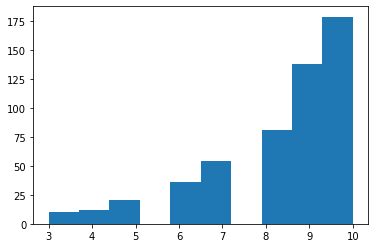

In [162]:
print(context_sizes_df['size'].describe())
plt.hist(context_sizes_df['size'].values)

In [175]:
final_data = DataHandler(filtered_arguments)

In [176]:
import time
ts = time.time()

In [177]:
ts

1632239915.4824035

In [178]:
args = final_data.get_filtered_arguments([
    DataHandler.get_args_filter_length(length=3),
    DataHandler.get_args_filter_context_size(length=2)
])
print(len(args))

4431


In [179]:
final_data.dump_data(f'../../not-gitted/argsme-crawled/{ts}-4431-arguments-cleaned.pickle')

In [182]:
with open(f'../../not-gitted/argsme-crawled/{ts}-4431-arguments-cleaned.stance', 'w', encoding='utf-8') as file:
    json.dump(stances, file)